# Вступление
Цель - создать набор данных и простую (1 скрытый слой) сеть для целей классификации. Я хочу, чтобы все было как можно более замкнутым. Возможно, есть более гибкие конструкции, но я сосредоточен только на решении классификатора цифр MNIST.

Прежде всего, полезный импорт.

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import os
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


## 1. Создайем загрузчики данных
Самым сложным здесь было получение правильных форм и типов. Есть 2 объекта: один для обучающего набора (который возвращает данные и истинную метку) и один для тестового набора (который возвращает только данные).
Поскольку в этой простой модели нас не интересует форма, данные возвращаются в виде вектора длиной 784.

In [2]:
class KaggleMNIST(Dataset):
    """Пользовательский набор данных для использования с pytorch.
     Даже если у pytorch есть набор данных MNIST, для участия в Kaggle
     конкуренция, нам лучше использовать набор данных Kaggle.
     Этот класс загружает только набор данных поезда (изображения + метки).
    """
    
    def __init__(self, path):
        data = np.loadtxt(path + 'train.csv', delimiter=',', skiprows=1, dtype=np.float32)
        self._digits = torch.from_numpy(data[:, 1:]) / 255
        self._labels = torch.from_numpy(data[:, 0]).type(torch.long)
        self._size = len(data)
        print('Training dataset with MNIST digits loaded.')
        print('  Digits has shape:', self._digits.shape)
        print('  Labels has shape:', self._labels.shape)
        
    def __getitem__(self, idx):
        return (self._digits[idx], self._labels[idx])
    
    def __len__(self):
        return self._size
    
class KaggleMNIST_test(Dataset):
    """Пользовательский набор данных для использования с pytorch.
     Даже если у pytorch есть набор данных MNIST, для участия в Kaggle
     конкуренция, нам лучше использовать набор данных Kaggle.
     Этот класс загружает только тестовый набор данных (изображения).
    """
    
    def __init__(self, path):
        data = np.loadtxt(path + 'test.csv', delimiter=',', skiprows=1, dtype=np.float32)
        self._digits = torch.from_numpy(data) / 256
        self._size = len(data)
        print('Testing dataset with MNIST digits loaded.')
        print('  Digits has shape:', self._digits.shape)
        
    def __getitem__(self, idx):
        return self._digits[idx]
    
    def __len__(self):
        return self._size

## 2. Вспомогательная функция
Цель этой функции - уменьшить беспорядок.

In [3]:
def create_samplers(size, train_prop):
    """Функция, которая создает 2 подмножества из набора обучающих данных, одно из которых
     используйте din-обучение, а другое - для проверки.
    
     Параметры
     ----------
     размер: числовой, целочисленный.
         Количество элементов в наборе данных, которые нужно разделить на набор поездов и
         набор для проверки.
     train_prop: Числовое, с плавающей запятой.
         Число от 0 до 1, определяющее пропорцию элементов.
         который будет включен в набор для проверки.

     Return
     -------
     Кортеж с двумя объектами SubsetRandomSampler, первый из которых будет использоваться с
     обучающий DataLoader, а второй - с проверкой DataLoader.
    """
    cut_point = int(size * train_prop)
    shuffled = np.random.permutation(size)
    train_sampler = SubsetRandomSampler(shuffled[:cut_point])
    validation_sampler = SubsetRandomSampler(shuffled[cut_point:])
    return train_sampler, validation_sampler

## 3. Модель
Для этой задачи функцией потерь является кросс-энтропия, а оптимизация выполняется с помощью стохастического градиентного спуска. Скрытые слои имеют функцию активации LeakyReLU, но я не видел, чтобы она была лучше или хуже, чем простой ReLU. Использование signoid показало несколько худшие результаты. Больше ничего не пробовал.
Модель принимает заряжающие, а точность встроена.
Проверка - это частный метод, поскольку он используется во время обучения, а результаты (эволюция потерь и точности) выводятся на экран и возвращаются методом fit () в случае, если пользователь хочет что-то сделать.

In [4]:
class MLP_1_HL_Classification(nn.Module):
    """Простой многослойный перцептрон с одним скрытым слоем, использующий
     LeakyReLU как функция активации и кросс-энтропия как функция потерь,
     быть примененным к задачам классификации.
     Первая попытка поместить все в объект, поэтому модель
     самодостаточный. Не уверен, действительно ли это необходимо.
    """

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self._input_size = input_size
        self._hidden_size = hidden_size
        self._output_size = output_size
        self.train_loader = None
        self.validation_loader = None
        self._optimizer_fn = torch.optim.SGD
        self._loss_fn = F.cross_entropy
        self._net = nn.Sequential(
            nn.Linear(self._input_size, self._hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self._hidden_size, self._output_size))
        
    def forward(self, batch):
        return self._net(batch)
    
    def define_loaders(self, train, validation):
        self.train_loader = train
        self.validation_loader = validation
            
    def _accuracy(self, outputs, labels):
        preds = torch.max(outputs, dim=1)[1]
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))
                
    def _validation_with_batch(self, batch):
        images, labels = batch 
        preds = self(images)
        loss = self._loss_fn(preds, labels, reduction='sum')
        acc = self._accuracy(preds, labels) * len(labels)
        return {'loss': loss, 'accuracy': acc}
        
    def _evaluate(self):
        with torch.no_grad():
            outputs = [self._validation_with_batch(batch) for batch in self.validation_loader]
        samples = len(self.validation_loader.sampler.indices)
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).sum() / samples
        batch_accuracies = [x['accuracy'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracies).sum() / samples
        return {'loss': epoch_loss.item(), 'accuracy': epoch_accuracy.item()}
    
    def fit(self, epochs, learning_rate):
        print(f'Training the model for {epochs} epochs with learning rate {learning_rate}.')
        optim = self._optimizer_fn(self.parameters(), learning_rate)
        history = []
        for epoch in range(epochs):
            # Training Phase 
            for batch in self.train_loader:
                images, labels = batch 
                loss = self._loss_fn(self(images), labels)
                loss.backward()
                optim.step()
                optim.zero_grad()
            # Оценка эпох с помощью набора данных проверки.
            result = self._evaluate()
            print("Epoch [{}], loss: {:.4f}, accuracy: {:.4f}".format(epoch, result['loss'], result['accuracy']))
            history.append(result)
        return history  


## 4. Загрузка данных

In [5]:
train_set = KaggleMNIST('../input/digit-recognizer/')
test_set = KaggleMNIST_test('../input/digit-recognizer/')

Training dataset with MNIST digits loaded.
  Digits has shape: torch.Size([42000, 784])
  Labels has shape: torch.Size([42000])
Testing dataset with MNIST digits loaded.
  Digits has shape: torch.Size([28000, 784])


## 5. Дальнейшая настройка

In [6]:
batch_size = 80
hidden_layer = 500

train_sampler, validation_sampler = create_samplers(len(train_set), 0.8)

print(f'Size of training set: {len(train_sampler.indices)}.')
print(f'Size of validation set: {len(validation_sampler.indices)}.')

train_loader = DataLoader(train_set, batch_size, sampler = train_sampler)
validation_loader = DataLoader(train_set, batch_size, sampler = validation_sampler)

Size of training set: 33600.
Size of validation set: 8400.


## 6. Создайте модель и обучите ее
Учитывая, что мы знаем набор данных, размеры входного и выходного слоев являются константами.

Метод подгонки предназначен для последовательных вызовов, изменяющих эпохи и скорость обучения. Показанные здесь были найдены методом проб и ошибок. Эта сеть, кажется, имеет максимальную точность 97%, и большее количество эпох или больший скрытый слой не улучшают ее, по крайней мере, в моих попытках.

In [7]:
model = MLP_1_HL_Classification(784, hidden_layer, 10)
model.define_loaders(train_loader, validation_loader)

model.fit(3, 0.15)
model.fit(3, 0.1)
model.fit(5, 0.05)
model.fit(4, 0.025)
model.fit(4, 0.01)
model.fit(4, 0.005)

result0 = model._evaluate()
print(result0)

Training the model for 3 epochs with learning rate 0.15.
Epoch [0], loss: 0.3043, accuracy: 0.9095
Epoch [1], loss: 0.2207, accuracy: 0.9352
Epoch [2], loss: 0.1809, accuracy: 0.9477
Training the model for 3 epochs with learning rate 0.1.
Epoch [0], loss: 0.1612, accuracy: 0.9507
Epoch [1], loss: 0.1479, accuracy: 0.9544
Epoch [2], loss: 0.1393, accuracy: 0.9567
Training the model for 5 epochs with learning rate 0.05.
Epoch [0], loss: 0.1331, accuracy: 0.9592
Epoch [1], loss: 0.1299, accuracy: 0.9601
Epoch [2], loss: 0.1236, accuracy: 0.9608
Epoch [3], loss: 0.1205, accuracy: 0.9613
Epoch [4], loss: 0.1189, accuracy: 0.9620
Training the model for 4 epochs with learning rate 0.025.
Epoch [0], loss: 0.1166, accuracy: 0.9633
Epoch [1], loss: 0.1152, accuracy: 0.9642
Epoch [2], loss: 0.1149, accuracy: 0.9637
Epoch [3], loss: 0.1125, accuracy: 0.9648
Training the model for 4 epochs with learning rate 0.01.
Epoch [0], loss: 0.1118, accuracy: 0.9646
Epoch [1], loss: 0.1115, accuracy: 0.9648
E

## 7. Вывод

In [10]:
predictions = [[idx+1, torch.max(model(point), dim=1)[1].item()] for idx, point in enumerate(DataLoader(test_set))]
submission = pd.DataFrame(predictions, columns=['ImageId', 'Label'])
submission.to_csv("submission.csv", index=False)

# Модель №2

In [ ]:
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
print(train_data.shape)
print(train_data.head())
# изображения сглаживаются (каждая строка содержит значения для одного изображения)
# нам нужно изменить его форму, чтобы получить матрицу изображения (значения пикселей в оттенках серого в матрице 28 x 28)
# но сначала мы разделяем метки и предикторы (y и x соответственно)
# и преобразовать из фрейма данных Pandas в матрицу numpy (это то, что делает .values)

X = (train_data.iloc[:, 1:].values).astype('float32')
y = (train_data.iloc[:, 0].values).astype('int32')

In [ ]:
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
print(test_data.shape)
test_data.head()
X_test = test_data.values.astype('float32')


In [ ]:
submission_data = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
print(submission_data.shape)
submission_data.head()

In [ ]:
img_rows, img_cols = 28, 28
num_classes = 10  # digits 0 - 9

X_train = X.reshape(X.shape[0], img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols)

In [ ]:
# Построим изображения для проверки работоспособности

for i in range(5, 8):
    plt.subplot(130 + (-4+i))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y[i])
    plt.xticks([])
    plt.yticks([])

In [ ]:
# добавим еще одно измерение для цветового канала
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)


In [ ]:
# нормализуем значения пикселей для упрощения обработки
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
# кодируем метки одним горячим кодировщиком (конвертировать в отдельные категории)
y_train = to_categorical(y)


In [ ]:
# разделим данные на набор для обучения и проверки (используется только для увеличения изображения, в противном случае выполняется при подгонке)
X_gen, X_val, y_gen, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:

# применим некоторые улучшения к данным изображений, чтобы увеличить обучающие данные
datagen = ImageDataGenerator(rotation_range=10,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)
datagen.fit(X_gen)

In [ ]:
# собрем модель
model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 # pads the "frames" of the image with 0's, so that convolution reaches the edges
                 padding='same',
                 input_shape=(img_rows, img_cols, 1)))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=(5, 5),
                 padding='same',
                 activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(12, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(64, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
# сводка модели
model.summary()


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# обучим модель
model.fit(datagen.flow(X_gen, y_gen, batch_size=420),
                    epochs=6,
                    validation_data=(X_val, y_val))


In [ ]:
# сделаем прогноз
preds = model.predict(X_test)
print(preds)

In [ ]:
# Вывод
submissions = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submissions["Label"] = preds.astype('int32')
submissions.to_csv('submissions_TWO.csv', index = False)

# Вывод
submissions = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submissions["Label"] = preds.astype('int32')
submissions.to_csv('submissions_TWO.csv', index = False)

In [11]:
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
print(train_data.shape)
print(train_data.head())
# изображения сглаживаются (каждая строка содержит значения для одного изображения)
# нам нужно изменить его форму, чтобы получить матрицу изображения (значения пикселей в оттенках серого в матрице 28 x 28)
# но сначала мы разделяем метки и предикторы (y и x соответственно)
# и преобразовать из фрейма данных Pandas в матрицу numpy (это то, что делает .values)

X = (train_data.iloc[:, 1:].values).astype('float32')
y = (train_data.iloc[:, 0].values).astype('int32')

(42000, 785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0      

In [12]:
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
print(test_data.shape)
test_data.head()
X_test = test_data.values.astype('float32')


(28000, 784)


In [13]:
submission_data = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
print(submission_data.shape)
submission_data.head()

(28000, 2)


,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [15]:
img_rows, img_cols = 28, 28
num_classes = 10  # digits 0 - 9

X_train = X.reshape(X.shape[0], img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols)

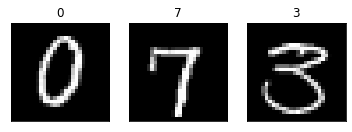

In [16]:
# Построим изображения для проверки работоспособности

for i in range(5, 8):
    plt.subplot(130 + (-4+i))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y[i])
    plt.xticks([])
    plt.yticks([])

In [17]:
# добавим еще одно измерение для цветового канала
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)


In [18]:
# нормализуем значения пикселей для упрощения обработки
X_train = X_train / 255
X_test = X_test / 255

In [19]:
# кодируем метки одним горячим кодировщиком (конвертировать в отдельные категории)
y_train = to_categorical(y)


In [20]:
# разделим данные на набор для обучения и проверки (используется только для увеличения изображения, в противном случае выполняется при подгонке)
X_gen, X_val, y_gen, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [21]:

# применим некоторые улучшения к данным изображений, чтобы увеличить обучающие данные
datagen = ImageDataGenerator(rotation_range=10,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)
datagen.fit(X_gen)

In [22]:
# собрем модель
model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 # pads the "frames" of the image with 0's, so that convolution reaches the edges
                 padding='same',
                 input_shape=(img_rows, img_cols, 1)))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=(5, 5),
                 padding='same',
                 activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(12, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(64, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [24]:
# сводка модели
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 12)        3468      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 12)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 12)        0

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [27]:
# обучим модель
model.fit(datagen.flow(X_gen, y_gen, batch_size=420),
                    epochs=6,
                    validation_data=(X_val, y_val))


Epoch 1/6
90/90 [==============================] - 166s 2s/step - loss: 0.8629 - acc: 0.7110 - val_loss: 0.1101 - val_acc: 0.9676
Epoch 2/6
90/90 [==============================] - 165s 2s/step - loss: 0.2307 - acc: 0.9308 - val_loss: 0.0717 - val_acc: 0.9783
Epoch 3/6
90/90 [==============================] - 166s 2s/step - loss: 0.1642 - acc: 0.9506 - val_loss: 0.0627 - val_acc: 0.9829
Epoch 4/6
90/90 [==============================] - 165s 2s/step - loss: 0.1324 - acc: 0.9610 - val_loss: 0.0473 - val_acc: 0.9852
Epoch 5/6
90/90 [==============================] - 165s 2s/step - loss: 0.1175 - acc: 0.9653 - val_loss: 0.0401 - val_acc: 0.9895
Epoch 6/6
90/90 [==============================] - 166s 2s/step - loss: 0.1014 - acc: 0.9703 - val_loss: 0.0379 - val_acc: 0.9879


In [28]:
# сделаем прогноз
preds = model.predict(X_test)
print(preds)

[[3.0120140e-07 6.7529612e-07 9.9996471e-01 ... 1.0151785e-05
  3.6755114e-07 4.9087969e-08]
 [9.9938703e-01 7.5898070e-09 9.0216290e-06 ... 1.0980252e-06
  4.3695527e-06 4.9173768e-04]
 [1.1165035e-05 3.7490777e-06 8.7428252e-06 ... 4.6145833e-05
  1.2953163e-02 9.8572218e-01]
 ...
 [3.5540404e-11 2.5741247e-09 9.1847738e-09 ... 3.7656314e-08
  2.8874135e-08 1.8997233e-07]
 [2.0595703e-06 2.2419535e-08 4.6523478e-08 ... 8.5959065e-05
  5.8658775e-06 9.9953437e-01]
 [2.9607386e-07 1.3874962e-08 9.9998260e-01 ... 5.5512182e-08
  1.2524271e-05 2.7238805e-08]]


In [30]:
# Вывод
submissions = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submissions["Label"] = preds.astype('int32')
submissions.to_csv('submissions_TWO.csv', index = False)